In [ ]:
!pip install git+https://github.com/MassimoStel/emoatlas

  Cloning https://github.com/MassimoStel/emoatlas to /tmp/pip-req-build-_0l2u6sg
  Running command git clone --filter=blob:none --quiet https://github.com/MassimoStel/emoatlas /tmp/pip-req-build-_0l2u6sg
  Resolved https://github.com/MassimoStel/emoatlas to commit 7b8133769fed0f948740d6f02f9bed7ed0528424
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.4 MB/s eta 0:00:00
  Created wheel for emoatlas: filename=emoatlas-0.2.0-py3-none-any.whl size=3766548 sha256=d554407709049faa1412179eb3ddec1ca01184775ec97a8b3735de2bbafc005b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3g20lpea/wheels/17/01/fa/b9ac611d4fc0ea8c9ee75459aff66b55e0b03dc48ce582b66a
Successfully built emoatlas


In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download it_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# >>> OPTION A: directly type the full path to your CSV inside Colab
PATH = "/content/emoatlas_csv.csv"   # <- change if your filename differs

# --- If you need alternatives, uncomment ONE of the blocks below ---

# OPTION B: manual upload from your computer (small files)
# from google.colab import files
# uploaded = files.upload()         # pick the CSV
# PATH = next(iter(uploaded.keys()))  # first uploaded name

# OPTION C: use Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# PATH = "/content/drive/MyDrive/your_folder/Emo_atlas_Fİle_csv.csv"


In [ ]:
import pandas as pd, re

# Your file is semicolon-separated and has UTF-8 with BOM
df = pd.read_csv(PATH, sep=';', encoding='utf-8-sig', engine='python')

# Tidy column names and strip non-breaking spaces
df.columns = [re.sub(r"\s+", " ", c).replace("\xa0"," ").strip() for c in df.columns]
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.replace("\xa0"," ", regex=False).str.strip()

# Map groups and languages to consistent labels
group_map = {1: "ASC", 2: "Control", "1": "ASC", "2": "Control"}
df["GroupLabel"] = df["GROUP"].map(group_map).fillna(df["GROUP"])

lang_map = {"EN":"english","IT":"italian","en":"english","it":"italian"}
df["lang_norm"] = df["UserLanguage"].map(lang_map).fillna("english")

print(df.head(3))
print("Rows:", len(df))


                                         Description UserLanguage  GROUP  \
0  This painting remind me of an escape from the ...           EN      1   
1  This work, the transition of people to each ot...           EN      1   
2  I see people hugging each other and trying to ...           EN      1   

  GroupLabel lang_norm  
0        ASC   english  
1        ASC   english  
2        ASC   english  
Rows: 74


In [ ]:
from emoatlas import EmoScores
from tqdm import tqdm
import pandas as pd

# The 8 Plutchik emotions (in fixed order)
EMOTIONS = ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]

# Cache models (avoid reloading spaCy for each participant)
models = {
    "english": EmoScores(language="english"),
    "italian": EmoScores(language="italian"),
}

def zscores_for_row(text, lang):
    """
    Extracts standardized emotion z-scores from EmoAtlas for a given text.
    Uses emo.zscores() if available (v≥0.4), otherwise falls back to
    emo.emotional_profile(use_zscores=True) for older versions.
    """
    emo = models.get(lang, models["english"])

    try:
        # Preferred API (latest EmoAtlas versions)
        z = emo.zscores(text)
    except AttributeError:
        # Fallback for older versions
        z = emo.emotional_profile(text, use_zscores=True)

    # Ensure all 8 emotions are present in fixed order
    return {f"{e}_z": float(z.get(e, 0.0)) for e in EMOTIONS}

# Apply across all rows in your DataFrame
rows = []
for _, r in tqdm(df.iterrows(), total=len(df)):
    rows.append(zscores_for_row(r["Description"], r["lang_norm"]))

# Combine results into your main dataframe
zdf = pd.DataFrame(rows)
out = pd.concat([df.reset_index(drop=True), zdf], axis=1)

# Preview the results
out.head()



100%|██████████| 74/74 [00:01<00:00, 67.88it/s]


,Description,UserLanguage,GROUP,GroupLabel,lang_norm,joy_z,trust_z,fear_z,surprise_z,sadness_z,disgust_z,anger_z,anticipation_z
0,This painting remind me of an escape from the ...,EN,1,ASC,english,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"This work, the transition of people to each ot...",EN,1,ASC,english,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,I see people hugging each other and trying to ...,EN,1,ASC,english,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,It makes me feel both joy and suffering at the...,EN,1,ASC,english,0.756872,-0.636845,-0.632979,-0.828795,0.714584,-0.086253,-1.373153,1.066749
4,un’unione di corpi felici e colorati in primav...,IT,1,ASC,italian,3.897570,0.137552,-1.755510,-1.030142,-0.490693,-1.397723,-1.613125,-0.186260


In [ ]:
import numpy as np

# Positive / Negative / Arousal-ish / Balance / Entropy
out["pos_aff"]  = out["joy_z"] + out["trust_z"]
out["neg_aff"]  = out["sadness_z"] + out["disgust_z"] + out["anger_z"] + out["fear_z"]
out["arousalish"] = out["surprise_z"] + out["anger_z"] + out["fear_z"]
out["posneg_balance"] = out["pos_aff"] - out["neg_aff"]

# Emotion diversity (entropy of the 8 z-scores after making them positive)
eps = 1e-8
vec = out[[f"{e}_z" for e in EMOTIONS]].to_numpy()
vec_min = vec.min(axis=1, keepdims=True)
vec_shift = (vec - vec_min) + eps
probs = vec_shift / vec_shift.sum(axis=1, keepdims=True)
entropy = -(probs * np.log(probs)).sum(axis=1)
out["emotion_entropy"] = entropy

out.head()


,Description,UserLanguage,GROUP,GroupLabel,lang_norm,joy_z,trust_z,fear_z,surprise_z,sadness_z,disgust_z,anger_z,anticipation_z,pos_aff,neg_aff,arousalish,posneg_balance,emotion_entropy
0,This painting remind me of an escape from the ...,EN,1,ASC,english,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,2.000000,-2.000000,7.039839e-07
1,"This work, the transition of people to each ot...",EN,1,ASC,english,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442e+00
2,I see people hugging each other and trying to ...,EN,1,ASC,english,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000,4.000000,6.931475e-01
3,It makes me feel both joy and suffering at the...,EN,1,ASC,english,0.805400,-0.549396,-0.644288,-0.843925,0.692994,-0.221846,-1.37811,1.459601,0.256004,-1.551249,-2.866322,1.807253,1.793005e+00
4,un’unione di corpi felici e colorati in primav...,IT,1,ASC,italian,3.904564,0.214178,-1.883507,-0.900549,-0.670411,-1.352371,-1.61355,-0.010483,4.118741,-5.519838,-4.397605,9.638579,1.572329e+00


In [ ]:
keep_cols = ["Description","UserLanguage","GROUP","GroupLabel","lang_norm"] \
            + [f"{e}_z" for e in EMOTIONS] \
            + ["pos_aff","neg_aff","arousalish","posneg_balance","emotion_entropy"]

out_csv  = "emoatlas_results.csv"
out_xlsx = "emoatlas_results.xlsx"

out[keep_cols].to_csv(out_csv, index=False)
out[keep_cols].to_excel(out_xlsx, index=False)

print("Saved:", out_csv, "and", out_xlsx)

# download to your machine (optional)
from google.colab import files
files.download(out_csv)
files.download(out_xlsx)


Saved: emoatlas_results.csv and emoatlas_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

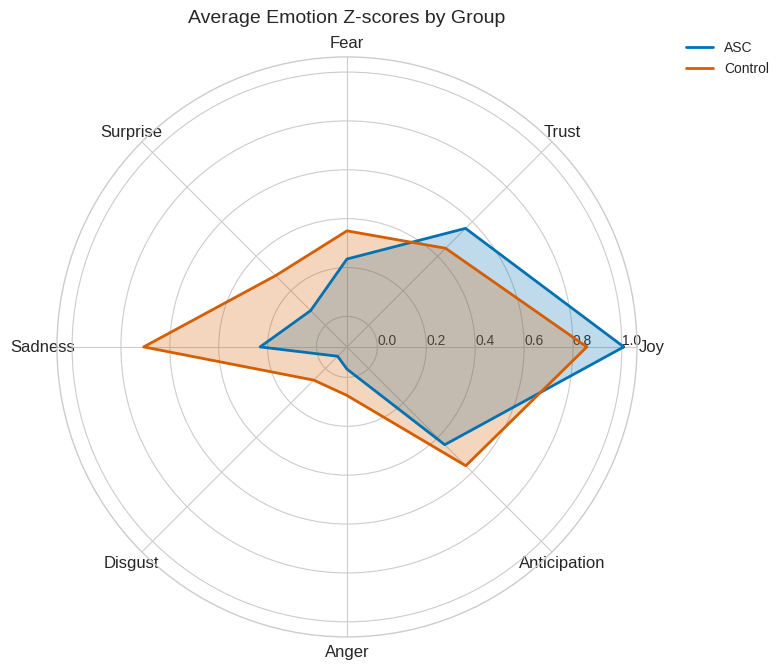

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure we use the same emotion order as EmoAtlas
EMOTIONS = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]

# Compute group means
mean_by_group = out.groupby("GroupLabel")[[f"{e}_z" for e in EMOTIONS]].mean()

# Reorder in circular order (Joy to Joy again for closure)
values_asc  = mean_by_group.loc["ASC"].to_list()
values_ctrl = mean_by_group.loc["Control"].to_list()
# close the circle
values_asc.append(values_asc[0])
values_ctrl.append(values_ctrl[0])

# Angle setup (8 emotions around a circle)
angles = np.linspace(0, 2*np.pi, len(EMOTIONS), endpoint=False).tolist()
angles += angles[:1]  # close loop

# --- Radar plot ---
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# ASC
ax.plot(angles, values_asc, linewidth=2, linestyle='solid', color="#0072B2", label="ASC")
ax.fill(angles, values_asc, color="#0072B2", alpha=0.25)

# Control
ax.plot(angles, values_ctrl, linewidth=2, linestyle='solid', color="#D55E00", label="Control")
ax.fill(angles, values_ctrl, color="#D55E00", alpha=0.25)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels([e.capitalize() for e in EMOTIONS], fontsize=12)
ax.set_rlabel_position(0)
ax.set_title("Average Emotion Z-scores by Group", size=14, pad=25)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()


Excluded 1 participant(s) for sadness outlier(s).
GroupLabel  sadness_z                                                                         Description
       ASC   4.275242 I corpi contorti mi trasmettono caos e sofferenza, ciò che mi colpisce di più è ...


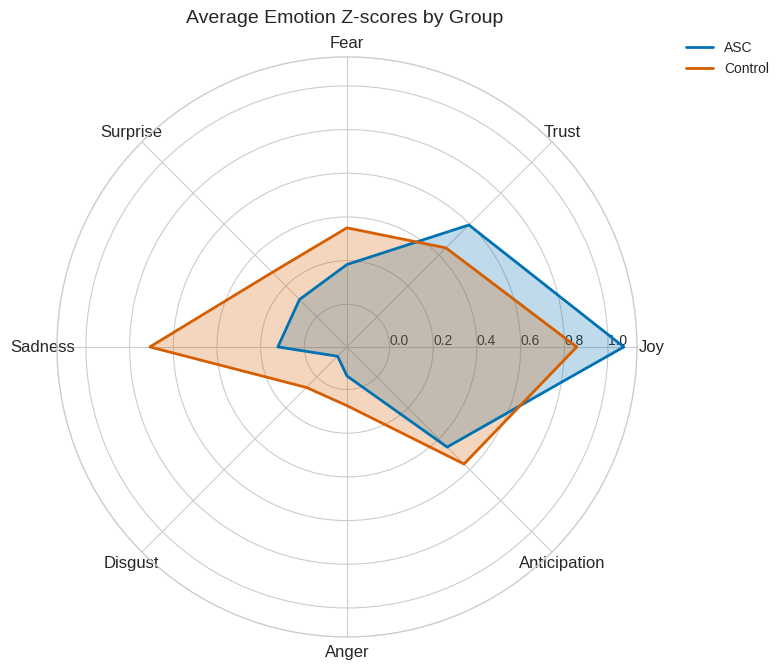

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore

# ----------------------------
# 1) Exclude the outlier(s)
# ----------------------------
# Compute within-group z-scores for sadness
out["sadness_zscore_within_group"] = out.groupby("GroupLabel")["sadness_z"].transform(zscore)

# ---- Option A (recommended): exclude |z| > 2.5 within group
exclude_mask = out["sadness_zscore_within_group"].abs() > 2.5

# ---- Option B (alternative): exclude a hard cutoff (uncomment if you prefer)
# exclude_mask = out["sadness_z"] > 4.0

excluded = out.loc[exclude_mask, ["GroupLabel","sadness_z","Description"]].copy()

# Keep a cleaned dataframe
out_clean = out.loc[~exclude_mask].copy()

print(f"Excluded {excluded.shape[0]} participant(s) for sadness outlier(s).")
if not excluded.empty:
    # Show a short preview so you know who was excluded
    print(excluded.assign(Description=excluded["Description"].str.slice(0,80) + "...").to_string(index=False))

# ----------------------------
# 2) Radar chart (group means)
# ----------------------------
EMOTIONS = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]

# Compute group means on the CLEAN data
mean_by_group = out_clean.groupby("GroupLabel")[[f"{e}_z" for e in EMOTIONS]].mean()

# Safety: ensure both groups are present
if not {"ASC","Control"}.issubset(set(mean_by_group.index)):
    missing = {"ASC","Control"} - set(mean_by_group.index)
    raise ValueError(f"Missing group(s) in cleaned data: {missing}. Check your filters or group labels.")

# Values in circular order (close the polygon)
values_asc  = mean_by_group.loc["ASC"].to_list()
values_ctrl = mean_by_group.loc["Control"].to_list()
values_asc.append(values_asc[0])
values_ctrl.append(values_ctrl[0])

# Angles for 8 emotions (close the circle)
angles = np.linspace(0, 2*np.pi, len(EMOTIONS), endpoint=False).tolist()
angles += angles[:1]

# --- Radar plot ---
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# ASC
ax.plot(angles, values_asc, linewidth=2, linestyle='solid', color="#0072B2", label="ASC")
ax.fill(angles, values_asc, color="#0072B2", alpha=0.25)

# Control
ax.plot(angles, values_ctrl, linewidth=2, linestyle='solid', color="#D55E00", label="Control")
ax.fill(angles, values_ctrl, color="#D55E00", alpha=0.25)

# Labels & cosmetics
ax.set_xticks(angles[:-1])
ax.set_xticklabels([e.capitalize() for e in EMOTIONS], fontsize=12)
ax.set_rlabel_position(0)
ax.set_title("Average Emotion Z-scores by Group ", size=14, pad=25)

# Optional: symmetric radius around zero (uncomment if you prefer fixed scale)
# ax.set_ylim(-3, 3)

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()


In [ ]:
emo = EmoScores(language="italian")
text11=" Si sta attraversando momenti nettamente distinti, che mi obbligano a ignorare e contemporaneamente ossessionarmi all' affetto tra umani, che cambia nel tempo, senza poterne riconoscere il volto."
emo.zscores(text11)


{'anger': 0,
 'trust': 2,
 'surprise': 0,
 'disgust': 0,
 'joy': 2,
 'sadness': 0,
 'fear': 0,
 'anticipation': 0}